In [15]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
import tqdm
from TCAE import *
from helper_functions import *
from image_processing_functions import *
from skimage.measure import label as label_connected_areas
from sklearn.metrics import jaccard_score

experiment_name = "next_frame_pred_am_sim_00"

base_dir = os.path.join(os.getcwd(),experiment_name)
weights_dir = os.path.join(base_dir,'weights')
whole_vid_pred_images_dir = os.path.join(base_dir,'whole_vid_pred')
gif_dir = os.path.join(base_dir,'gif')

# Create Directories to save results
create_dir(whole_vid_pred_images_dir)
create_dir(gif_dir)

In [2]:
# Instantiate model
latent_dim = 2048
tcae = TConvAutoEncoder(latent_dim)
# Load weights
# A 'dummy' forward pass is necessary to 'connect' model.
tcae((np.zeros((1,112,112,1), dtype = 'float32'), 
      np.zeros((1,1), dtype = 'float32'))
); 
# Select weigths with best validation loss
tcae.load_weights(sorted(glob.glob(weights_dir + '/*'))[2])

In [3]:
# Let's load some data to see the model's predictions
start_frame = 0
end_frame = 170
video_length = abs(start_frame - end_frame)
input_height = 112
input_width = 112
input_channels = 1

train_list = np.load(os.path.join(base_dir, 'train_list.npy'))
val_list = np.load(os.path.join(base_dir, 'val_list.npy'))
train_example = np.load(train_list[26])
val_example =  np.load(val_list[22])
train_example = np.expand_dims(train_example, -1)
val_example = np.expand_dims(val_example, -1)

In [4]:
def plot_perceptual_comparison(data, initial_frame, max_dt, n_im, figsize):
    '''
    Plot predictions along with Ground Truth images. 
    Top row contains TCAE predictions. Bottom row contains GT data.

    Args:
    data (numpy array): numpy array with GT data. shape = (n, height, width, channels)
    initial_frame (int): index for input frame.
    max_dt (int): Maximum change in time to predict.
    n_im (int): number of images per row. (equal to number of columns)
    figsize (tuple): Matplotlib figure size.
    '''
    cols = n_im
    rows = 2
    dt_array = np.linspace(0,max_dt,num = n_im)
    plt.figure(figsize = figsize)
    for i, dt in enumerate(dt_array):
        prediction = tcae.predict(
            (data[initial_frame:initial_frame+1], 
             np.array([[dt]], dtype = 'float32'))
        ) 
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(prediction[0,:,:,0])
        plt.axis("off")
        ax.set_title(f't = {initial_frame + dt}', fontsize = 10)
    for i, dt in enumerate(dt_array):
        ax = plt.subplot(rows, cols, n_im + i+1)
        plt.imshow(data[initial_frame + int(dt),:,:,0])
        plt.axis("off")

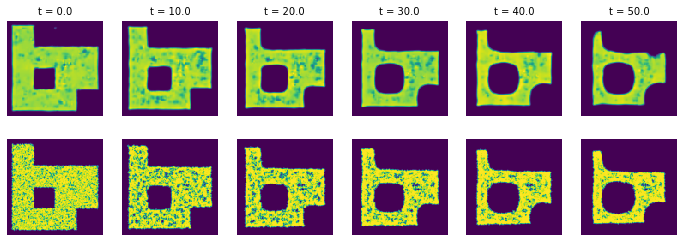

In [5]:
# Top row contains TCAE predictions
# Bottom row contains GT data
plot_perceptual_comparison(
    data = val_example, 
    initial_frame = 0, 
    max_dt = 50,
    n_im = 6,
    figsize = (12,4)
)

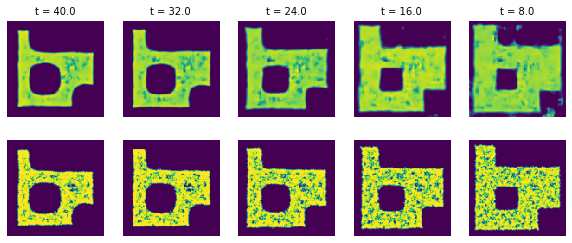

In [6]:
# Top row contains TCAE predictions
# Bottom row contains GT data
plot_perceptual_comparison(
    data = val_example, 
    initial_frame = 40, 
    max_dt = -32,
    n_im = 5,
    figsize = (10,4)
)

In [7]:
n = video_length
# Array to save our results, the total number of predicted samples is n squared.
video_predictions = np.zeros(shape=(n**2, input_height,input_width,input_channels))
# We will store all dt's needed in a single ordered array: [-(n-1),-(n_1)+1,...,0,...,n-2,n-1]
dt_array = np.arange(-(n-1), n, dtype = "float32")
# Array with time embedding scaled by all dt's: [-(n-1)(Φ), -(n_1)+1(Φ),...,0(Φ),...,n-2(Φ),n-1(Φ)]
time_embeddings =  tcae.time_embedding.predict(dt_array)
# Xt -> zt, Images in AM video to image embeddings
image_embeddings = tcae.encoder.predict(val_example)
# For all initial frames:
for i in tqdm.tqdm(range(image_embeddings.shape[0])):
    # Slicing of `time_embeddings` is a sliding window to the left starting at the end of the array.
    # zt + ΔtΦ, Time-translation in latent space
    translated_embeddings = image_embeddings[i:i+1] + time_embeddings[(n-1)-i:len(dt_array)-i]
    # Populate results array with predictions, (zt + ΔtΦ) -> X̃t+Δt
    video_predictions[n*i:n*(i+1),:,:] = tcae.decoder.predict(translated_embeddings)

100%|██████████| 170/170 [00:23<00:00,  7.20it/s]


In [8]:
input_frame = 40
for frame in tqdm.tqdm(range(n)):
    dts = dt_array[(n-1)-input_frame:len(dt_array)-input_frame]
    fig = plt.figure()
    ax1 = plt.subplot(1,2,1)
    plt.imshow(val_example[frame,:,:,0])
    plt.axis('off')
    plt.title(f'GT: t = {frame}')
    ax2 = plt.subplot(1,2,2)
    plt.imshow(video_predictions[(n*input_frame)+frame,:,:,0])
    plt.axis('off')
    plt.title(f'pred: input = {input_frame}, dt = {dts[frame]}')
    plt.savefig(
        os.path.join(whole_vid_pred_images_dir, f"whole_vid_pred_{str(frame).zfill(4)}"), 
        bbox_inches='tight',
        pad_inches=0.1,
    )
    plt.close()

100%|██████████| 170/170 [00:16<00:00, 10.41it/s]


In [9]:
gif_whole_vid_path = os.path.join(gif_dir,'tcae_whole_vid_pred.gif')
create_gif(gif_whole_vid_path, whole_vid_pred_images_dir)

100%|██████████| 170/170 [00:02<00:00, 59.38it/s]



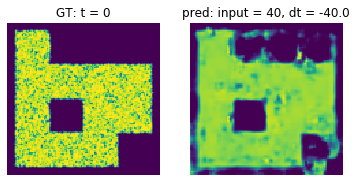

In [10]:
embed.embed_file(gif_whole_vid_path)

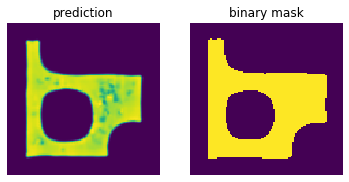

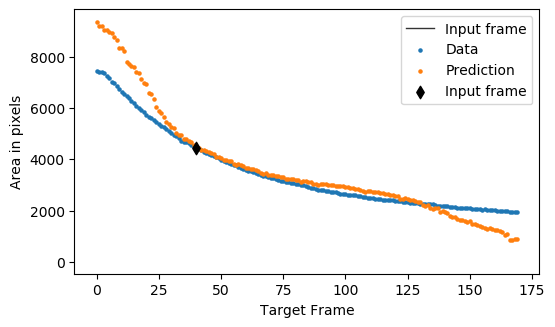

In [11]:
input_frame = 40
# Segmentation of microtubule network
mask_pred = thresholding(video_predictions[n*input_frame:n*(input_frame+1),:,:,:], method='triangle')
mask_pred = remove_objects(mask_pred, min_size=100)
mask_gt = thresholding(val_example, method='triangle')
mask_gt = remove_objects(mask_gt, min_size=100)
mask_gt = mask_gt.astype('int')

# Plot segmentation results
plt.subplot(1,2,1)
plt.imshow(video_predictions[n*input_frame:n*(input_frame+1),:,:,:][50,:,:,0])
plt.axis('off')
plt.title('prediction')
plt.subplot(1,2,2)
plt.imshow(mask_pred[50,:,:,0])
plt.axis('off');
plt.title('binary mask')
plt.show()

# Let's quantify the area of the binary masks
area_pred = count_pixels(mask_pred)
area_gt = count_pixels(mask_gt)
# Interpixel distance = .65 μm^2
# Images were downsampled from 2048x2048px --> 112x112px
# 1mm^2 = 1x10^6 μm^2 
true_area_pred = area_pred # * .65**2 * ((2048/112)**2) * 1e-6
true_area_gt = area_gt # * .65**2 * ((2048/112)**2) * 1e-6

# Plot area quantification results
plt.figure(dpi = 100, figsize= (6,3.5))
plt.scatter(range(video_length), true_area_gt, s =5 , label = 'Data')
plt.scatter(range(video_length), true_area_pred, s = 5, label = 'Prediction')
# diamond at input_frame
plt.scatter(input_frame, true_area_gt[input_frame], s = 40, c = 'k', marker = "d", label = 'Input frame')
# vertical line at input_frame
plt.plot([input_frame]*2, np.linspace(0,1, num=2), c = 'k', label = 'Input frame', linewidth = 1,alpha = .8)
# plt.ylim(0,.3)
# plt.xlim(20,150)
plt.xlabel("Target Frame")
plt.ylabel("Area in pixels")
plt.legend()
plt.show()

In [12]:
mask_video_predictions = thresholding(video_predictions, method='triangle')
mask_video_predictions = remove_objects(mask_video_predictions, min_size=100)
mask_video_predictions = mask_video_predictions.reshape(video_length,video_length,input_height,input_width)
# label disconnected areas
for input_frame in tqdm.tqdm(range(mask_video_predictions.shape[0])):
    for pred_frame in range(mask_video_predictions.shape[1]):
        labeled_areas = label_connected_areas(mask_video_predictions[input_frame, pred_frame], connectivity=2)
        # "remove" predictions with more than one disconnected area
        if labeled_areas.max() > 1:
            mask_video_predictions[input_frame, pred_frame] = np.zeros((input_height,input_width))

100%|██████████| 170/170 [00:06<00:00, 24.53it/s]


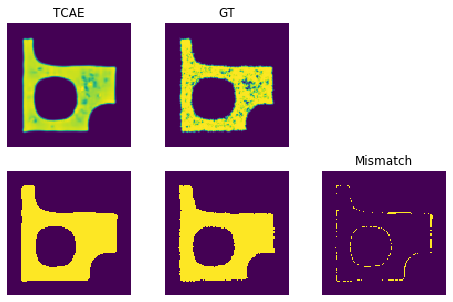

In [13]:
input_frame = 47
target_frame = 54 # target
fig = plt.figure(figsize = (8,5))
ax1 = plt.subplot(2,3,1)
plt.imshow(video_predictions[(n*input_frame)+target_frame,:,:,0])
plt.axis('off')
plt.title(f'TCAE')
ax2 = plt.subplot(2,3,2)
plt.imshow(val_example[target_frame,:,:,0])
plt.title(f'GT')
plt.axis('off')
ax3 = plt.subplot(2,3,4)
plt.imshow(mask_video_predictions[input_frame,target_frame,:,:])
plt.axis('off')
ax4 = plt.subplot(2,3,5)
plt.imshow(mask_gt[target_frame,:,:,0])
plt.axis('off')
ax5 = plt.subplot(2,3,6)
# Compute mismatch area:
mismatch = np.bitwise_xor(
    mask_gt[target_frame,:,:,0], 
    mask_video_predictions[input_frame,target_frame,:,:],
)
plt.imshow(mismatch)
plt.axis('off')
plt.title('Mismatch');

In [16]:
heatmap = np.zeros((video_length,video_length))
mask_gt_vectors = mask_gt.reshape((video_length,input_height*input_width))
true_areas = np.sum(mask_gt_vectors, axis = -1).astype('float32')
true_areas[np.where(true_areas == 0)] += 1e-6 # Add a small number to avoid dividing by zero
for input_frame in tqdm.tqdm(range(mask_video_predictions.shape[0])):
    mask_pred_vectors = mask_video_predictions[input_frame].reshape((video_length,input_height*input_width))
    jaccard_distance = [1 - jaccard_score(mask_gt_vectors[j],mask_pred_vectors[j])for j in range(video_length)]
#     mismatch_vectors = np.bitwise_xor(mask_gt_vectors, mask_pred_vectors)
#     mismatch_index = np.sum(mismatch_vectors, axis = -1)/true_areas
    heatmap[input_frame] = jaccard_distance

100%|██████████| 170/170 [01:39<00:00,  1.71it/s]


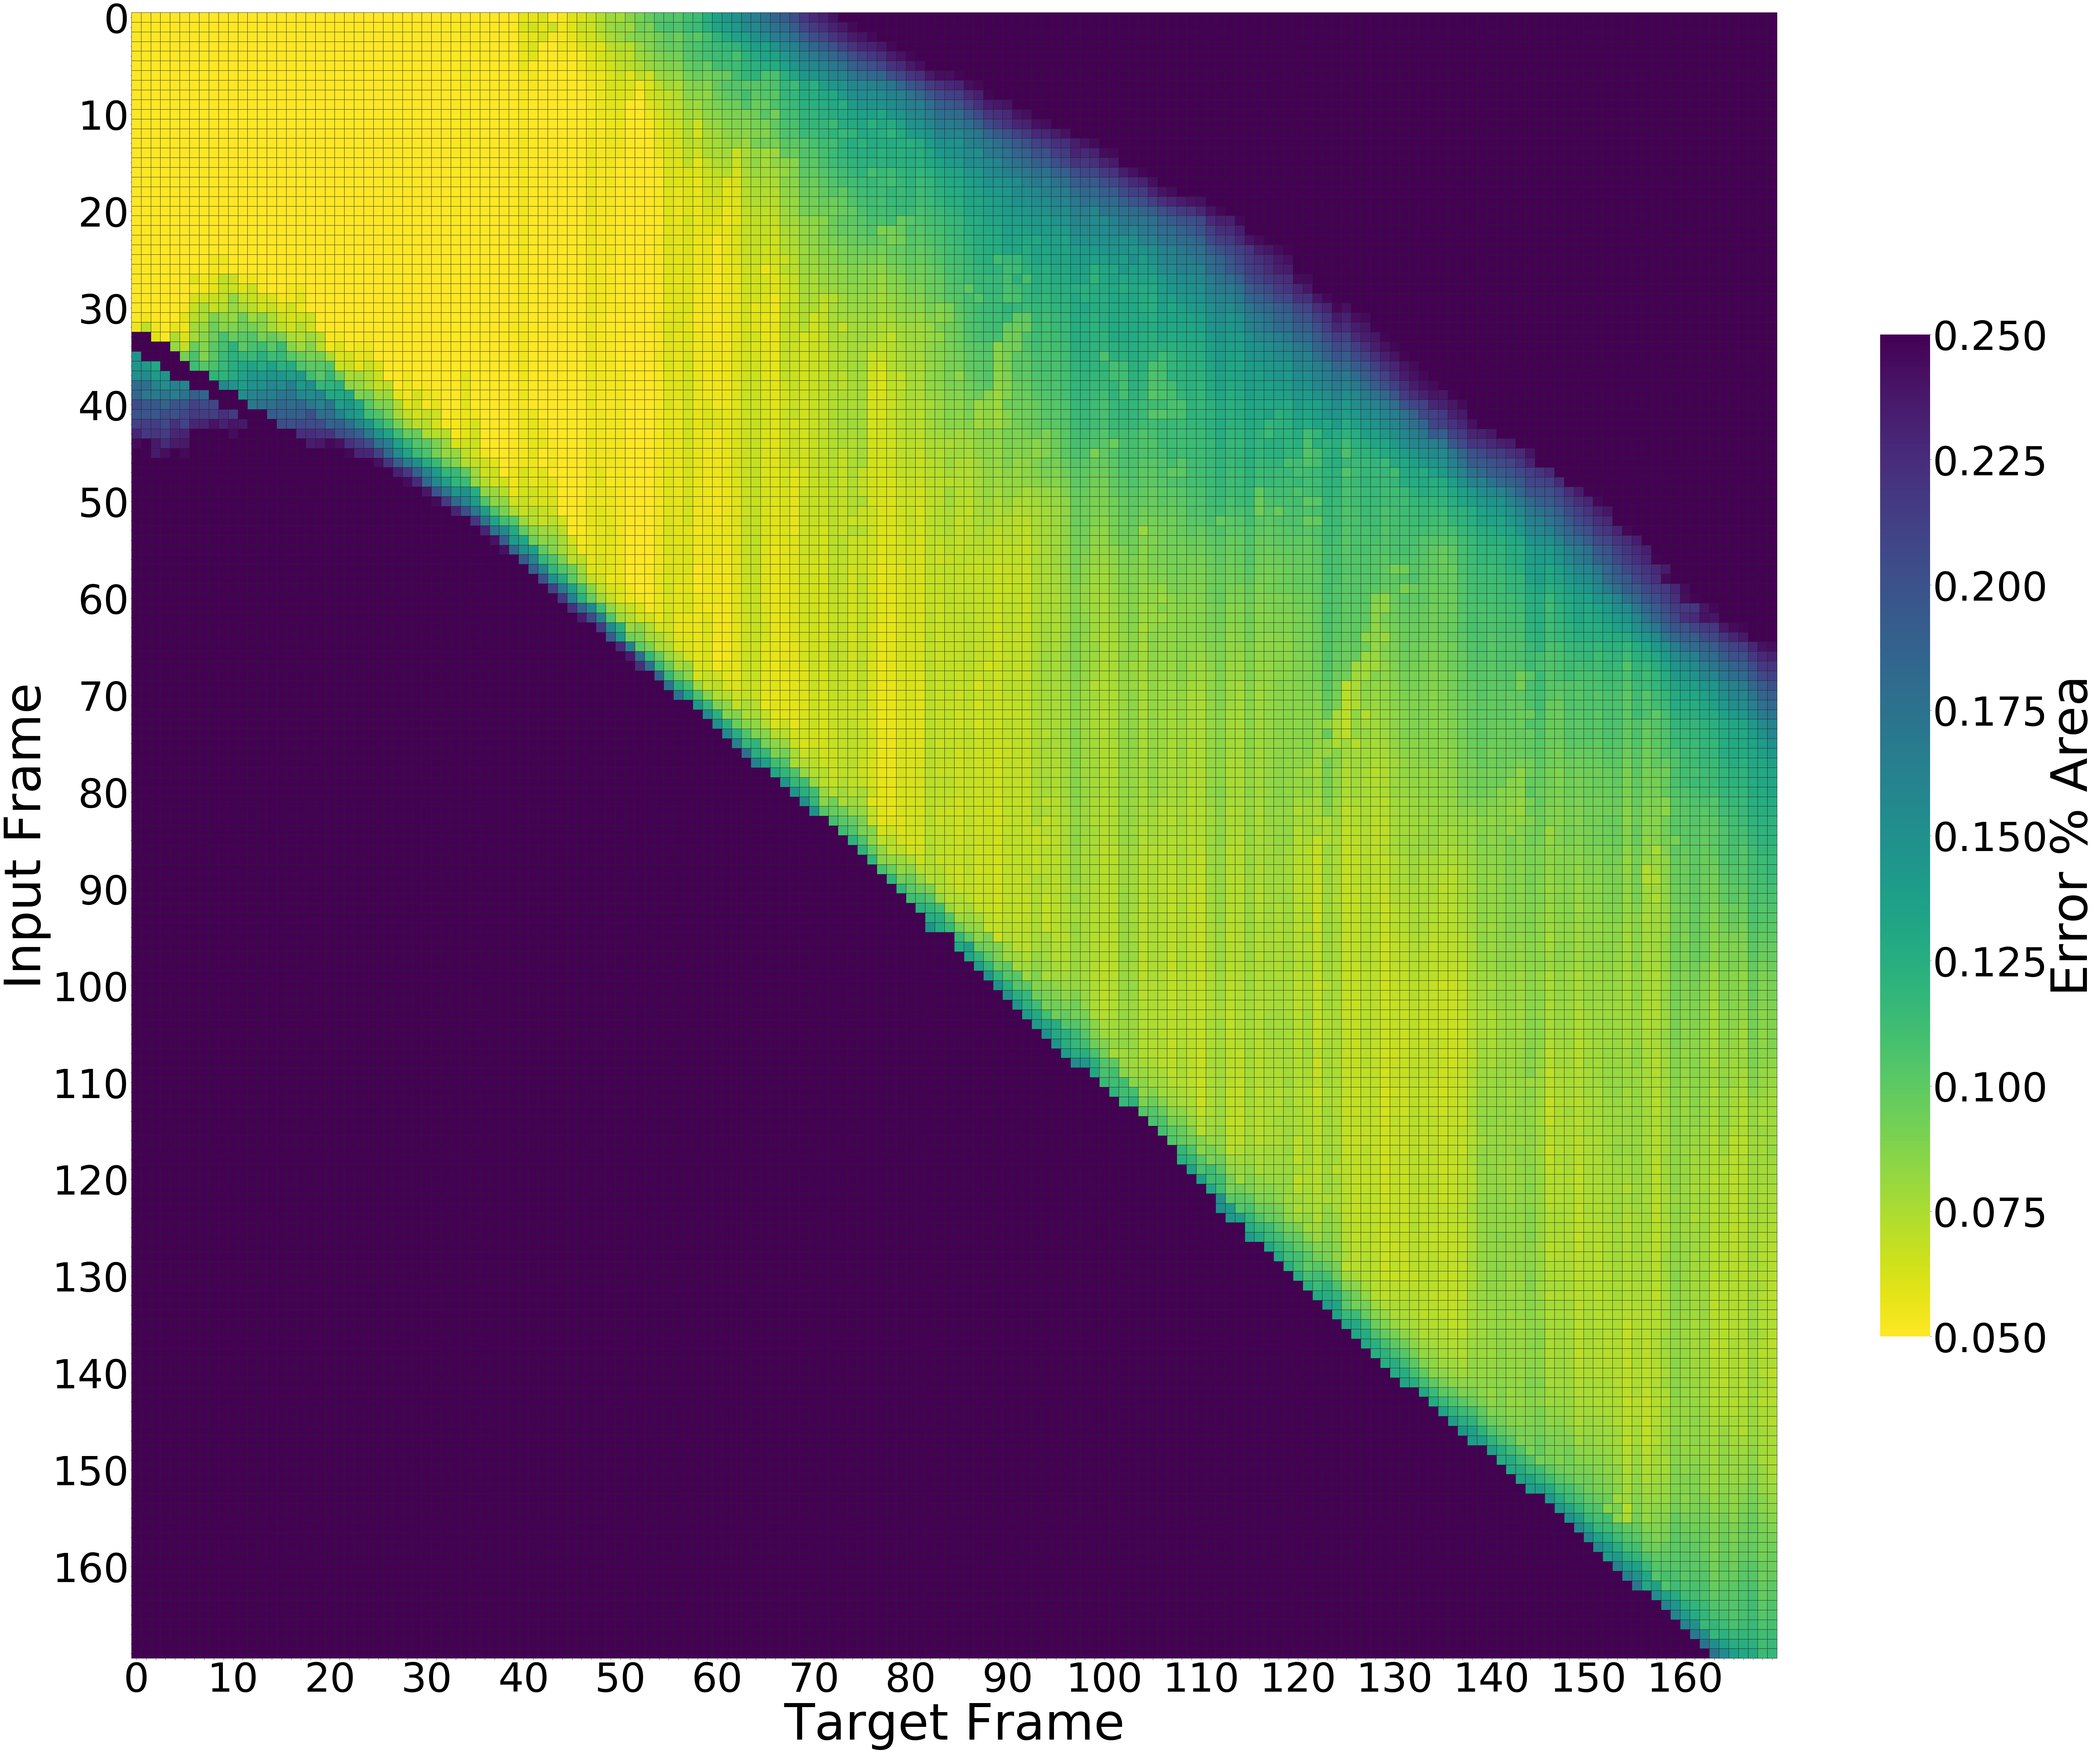

In [17]:
fig, ax = plt.subplots(figsize=(110,110))  
start = 0
end = 170
ax = sns.heatmap(
    heatmap[start:end, start:end], 
    vmin=0.05, 
    vmax=.25,
    cmap = 'viridis_r',
    linewidth=0.01,  # Add gridlines
    linecolor="222",
    square=True,
    cbar=True,
    xticklabels = [i  if i %10 == 0 else "" for i in range(start,end)],
    yticklabels = [i  if i %10 == 0 else "" for i in range(start,end)],
    cbar_kws={"shrink": 0.5, 'label': 'Error % Area', },
)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 120);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 120, rotation = 0);
ax.figure.axes[-1].yaxis.label.set_size(150)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=120)
plt.xlabel("Target Frame", fontsize = 150)
plt.ylabel("Input Frame", fontsize = 150);